# Hòa phát group 70 - 30

## Huấn luyện model

### Xử lý dữ liệu

In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('HSG Historical Data.csv',sep=",")
df1 = df.reset_index()['Price']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

# 5. Hàm Create Dataset (convert an array of values into a dataset matrix)
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Model  

In [2]:
# Define the RNN model
def create_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and train multiple GRU models
n_estimators = 10
predictions = []

for _ in range(n_estimators):
    base_model = create_rnn_model()
    base_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)
    y_pred = base_model.predict(X_test)
    predictions.append(y_pred.flatten())

# Average the predictions
bagging_predictions = np.mean(predictions, axis=0)

# Inverse transform the predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
bagging_predictions_inv = scaler.inverse_transform(bagging_predictions.reshape(-1, 1))

c:\Users\hangt\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.0181
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0014
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 8.7673e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.7374e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 6.9795e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 6.7378e-04
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 6.5813e-04
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 6.2285e-04
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 5.9446e-04
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 8.8716e-04
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 6.6421e-04
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 5.8284e-04
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 5.7738e-04
Epoch 15/10

## Đánh giá model

In [3]:
# 8. Dự đoán và đánh giá mô hình
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Inverse transform the true values for the testing data
true_values_testing = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE for testing data
test_mae = np.mean(abs(bagging_predictions_inv - true_values_testing))
print('Testing MAE:', test_mae)

# Calculate RMSE for testing data
rmse_testing = np.sqrt(mean_squared_error(true_values_testing, bagging_predictions_inv))
print(f'Testing RMSE: {rmse_testing}')

# Calculate MAPE for testing data
mape_testing = mean_absolute_percentage_error(true_values_testing, bagging_predictions_inv) * 100
print(f'Testing MAPE: {mape_testing}')

# Calculate MLSE for testing data
mlse_testing = np.mean((np.log1p(true_values_testing) - np.log1p(bagging_predictions_inv))**2)
print(f'Testing MLSE: {mlse_testing}')

# Calculate R-squared (R²) for testing data
r2_testing = r2_score(true_values_testing, bagging_predictions_inv)
print(f'Testing R²: {r2_testing}')

# Calculate Mean Squared Error (MSE) for testing data
mse_testing = mean_squared_error(true_values_testing, bagging_predictions_inv)
print(f'Testing MSE: {mse_testing}')

Testing MAE: 0.47654910839387105
Testing RMSE: 0.5009836414445881
Testing MAPE: 8.877027589001607
Testing MLSE: 0.005715025276558649
Testing R²: 0.2707947323396872
Testing MSE: 0.25098460899507957


## Dự đoán

### Dự đoán trên tập test

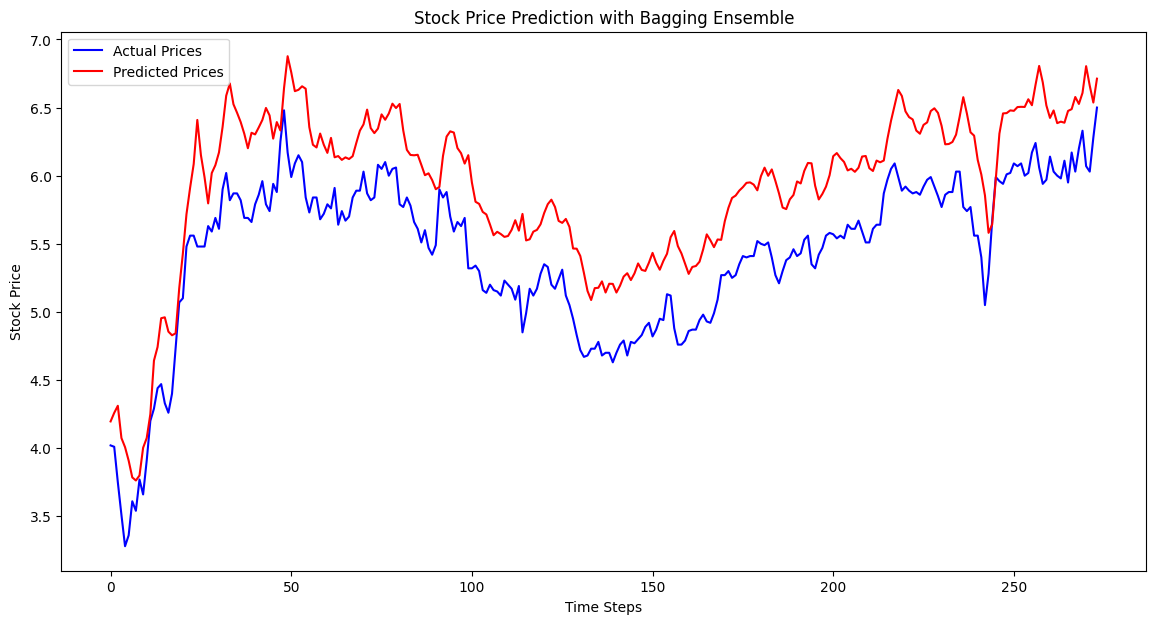

In [4]:
# Inverse transform the predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
bagging_predictions_inv = scaler.inverse_transform(bagging_predictions.reshape(-1, 1))

# Kích thước của biểu đồ
plt.figure(figsize=(14, 7))
# Vẽ biểu đồ
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(bagging_predictions_inv, label='Predicted Prices', color='red')
# Đặt tên cho các thông số
plt.title('Stock Price Prediction with Bagging Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
# Hiển thị biểu đồ
plt.show()

### Dự đoán tương lai

ValueError: x and y must have same first dimension, but have shapes (90,) and (89, 1)

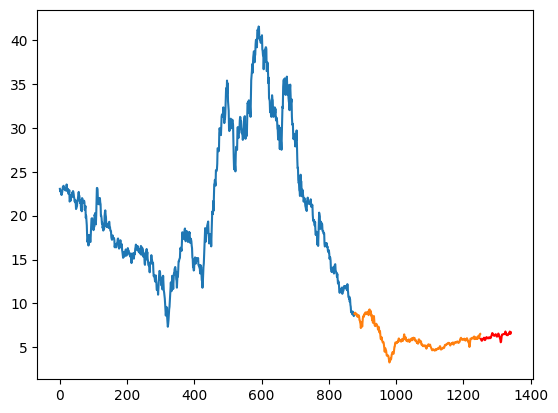

In [5]:
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

# Generate predictions for the next 90 days
for i in range(90):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))

        yhat = base_model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = base_model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

# Inverse transform the predictions for the next 90 days
final_predictions = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Plot the training data
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Training Data')

# Plot the testing data
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Testing Data')

# Plot the predicted prices with bagging
plt.plot(np.arange(len(df1), len(df1) + 90), bagging_predictions_inv[-90:], label='Predicted Prices (Bagging)', color='red')

# Plot the predicted prices for the next 90 days
next_90_days_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 90, step=1)
plt.plot(next_90_days_index, final_predictions, label='Predicted Prices (Next 90 Days)', color='purple')

plt.title('Stock Price Prediction with Bagging Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()